<a href="https://colab.research.google.com/github/kiki2-star/EVANS/blob/main/JKIA_POLLUTANTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
!pip install rasterio geopandas shapely


In [18]:
import os
import zipfile

pollutants_path = "/content/drive/MyDrive/Pollutants"
processed_path = "/content/drive/MyDrive/JKIA_Processed"
os.makedirs(processed_path, exist_ok=True)

# Unzip CH4 & SO2 if needed
for f in os.listdir(pollutants_path):
    if f.endswith(".zip"):
        zip_path = os.path.join(pollutants_path, f)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(pollutants_path)
        print(f"✅ Unzipped: {f}")


✅ Unzipped: JKIA_CH4-20251121T193734Z-1-001.zip
✅ Unzipped: JKIA_SO2-20251121T193632Z-1-001.zip


In [20]:
import geopandas as gpd
from shapely.geometry import Point

# JKIA coordinates (Terminal 1A)
jkia_point = Point(36.9275, -1.3192)

# Create GeoDataFrame
buffer_gdf = gpd.GeoDataFrame({'geometry': [jkia_point.buffer(0.18)]}, crs="EPSG:4326")
# 0.18 deg ≈ 20 km at equator, good enough for clipping

# Save buffer for processing
buffer_path = "/content/drive/MyDrive/JKIA_Processed/JKIA_buffer_20km.geojson"
buffer_gdf.to_file(buffer_path, driver="GeoJSON")
print("✅ JKIA buffer created and saved.")


✅ JKIA buffer created and saved.


In [21]:
import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np

# Load buffer
buffer_gdf = gpd.read_file(buffer_path)
buffer_geom = [feature["geometry"] for feature in buffer_gdf.__geo_interface__["features"]]

# Loop through pollutant folders
for pollutant in os.listdir(pollutants_path):
    folder_in = os.path.join(pollutants_path, pollutant)

    # Skip files, only process folders
    if not os.path.isdir(folder_in):
        continue

    folder_out = os.path.join(processed_path, pollutant)
    os.makedirs(folder_out, exist_ok=True)

    for f in os.listdir(folder_in):
        if f.endswith(".tif"):
            in_path = os.path.join(folder_in, f)
            out_path = os.path.join(folder_out, f)

            with rasterio.open(in_path) as src:

                # 1️⃣ Reproject to EPSG:4326 if needed
                dst_crs = 'EPSG:4326'
                kwargs = src.meta.copy()
                if src.crs != dst_crs:
                    transform, width, height = calculate_default_transform(
                        src.crs, dst_crs, src.width, src.height, *src.bounds)
                    kwargs.update({'crs': dst_crs, 'transform': transform, 'width': width, 'height': height})

                    dst_array = np.empty((src.count, height, width), dtype=src.meta['dtype'])
                    for i in range(1, src.count + 1):
                        reproject(
                            source=rasterio.band(src, i),
                            destination=dst_array[i - 1],
                            src_transform=src.transform,
                            src_crs=src.crs,
                            dst_transform=transform,
                            dst_crs=dst_crs,
                            resampling=Resampling.nearest
                        )
                else:
                    dst_array = src.read()

                # 2️⃣ Clip to buffer
                dst_array_clipped, clipped_transform = mask(
                    dataset=src,
                    shapes=buffer_geom,
                    crop=True
                )
                kwargs.update({
                    "height": dst_array_clipped.shape[1],
                    "width": dst_array_clipped.shape[2],
                    "transform": clipped_transform
                })

                # 3️⃣ Save processed raster
                with rasterio.open(out_path, 'w', **kwargs) as dst:
                    dst.write(dst_array_clipped)

                print(f"✅ Processed {pollutant}: {f}")

print("✅ All pollutants processed and saved to JKIA_Processed/")


✅ Processed JKIA_CO: CO_2024_11.tif
✅ Processed JKIA_CO: CO_2024_12.tif
✅ Processed JKIA_CO: CO_2024_10.tif
✅ Processed JKIA_CO: CO_2024_09.tif
✅ Processed JKIA_CO: CO_2024_07.tif
✅ Processed JKIA_CO: CO_2024_08.tif
✅ Processed JKIA_CO: CO_2024_06.tif
✅ Processed JKIA_CO: CO_2024_05.tif
✅ Processed JKIA_CO: CO_2024_04.tif
✅ Processed JKIA_CO: CO_2024_02.tif
✅ Processed JKIA_CO: CO_2024_03.tif
✅ Processed JKIA_CO: CO_2024_01.tif
✅ Processed JKIA_CO: CO_2023_11.tif
✅ Processed JKIA_CO: CO_2023_12.tif
✅ Processed JKIA_CO: CO_2023_09.tif
✅ Processed JKIA_CO: CO_2023_08.tif
✅ Processed JKIA_CO: CO_2023_07.tif
✅ Processed JKIA_CO: CO_2023_10.tif
✅ Processed JKIA_CO: CO_2023_05.tif
✅ Processed JKIA_CO: CO_2023_06.tif
✅ Processed JKIA_CO: CO_2023_03.tif
✅ Processed JKIA_CO: CO_2023_04.tif
✅ Processed JKIA_CO: CO_2023_02.tif
✅ Processed JKIA_CO: CO_2023_01.tif
✅ Processed JKIA_CO: CO_2022_12.tif
✅ Processed JKIA_CO: CO_2022_11.tif
✅ Processed JKIA_CO: CO_2022_10.tif
✅ Processed JKIA_CO: CO_2022

In [22]:
import os
import rasterio
import numpy as np

processed_path = "/content/drive/MyDrive/JKIA_Processed"
stack_path = "/content/drive/MyDrive/JKIA_Processed_Stacks"
os.makedirs(stack_path, exist_ok=True)


In [23]:
for pollutant in os.listdir(processed_path):
    folder = os.path.join(processed_path, pollutant)

    # Only folders
    if not os.path.isdir(folder):
        continue

    tif_files = sorted([f for f in os.listdir(folder) if f.endswith(".tif")])
    if len(tif_files) == 0:
        continue

    # Open first raster to get metadata
    with rasterio.open(os.path.join(folder, tif_files[0])) as src0:
        meta = src0.meta.copy()
        height, width = src0.height, src0.width
        count = len(tif_files)

    # Prepare array: time x height x width
    stack_array = np.empty((count, height, width), dtype=meta['dtype'])

    # Read each raster into stack
    for i, f in enumerate(tif_files):
        with rasterio.open(os.path.join(folder, f)) as src:
            stack_array[i] = src.read(1)

    # Save as multi-band GeoTIFF
    meta.update(count=count)
    stack_out = os.path.join(stack_path, f"{pollutant}_stack.tif")
    with rasterio.open(stack_out, 'w', **meta) as dst:
        for i in range(count):
            dst.write(stack_array[i], i + 1)

    print(f"✅ {pollutant} stack saved: {stack_out}")


✅ JKIA_CO stack saved: /content/drive/MyDrive/JKIA_Processed_Stacks/JKIA_CO_stack.tif
✅ JKIA_NO2 stack saved: /content/drive/MyDrive/JKIA_Processed_Stacks/JKIA_NO2_stack.tif
✅ JKIA_AOD stack saved: /content/drive/MyDrive/JKIA_Processed_Stacks/JKIA_AOD_stack.tif
✅ JKIA_AI stack saved: /content/drive/MyDrive/JKIA_Processed_Stacks/JKIA_AI_stack.tif
✅ JKIA_CH4 stack saved: /content/drive/MyDrive/JKIA_Processed_Stacks/JKIA_CH4_stack.tif
✅ JKIA_SO2 stack saved: /content/drive/MyDrive/JKIA_Processed_Stacks/JKIA_SO2_stack.tif


In [24]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

stack_path = "/content/drive/MyDrive/JKIA_Processed_Stacks"
charts_path = "/content/drive/MyDrive/JKIA_Charts"
os.makedirs(charts_path, exist_ok=True)


In [25]:
for stack_file in os.listdir(stack_path):
    if not stack_file.endswith(".tif"):
        continue

    pollutant = stack_file.split("_stack")[0]
    stack_file_path = os.path.join(stack_path, stack_file)

    with rasterio.open(stack_file_path) as src:
        # Read all bands into 3D array: time x height x width
        stack_array = src.read()  # shape: (bands, height, width)

    # 1️⃣ Monthly average (mean over pixels per band)
    monthly_avg = stack_array.reshape(stack_array.shape[0], -1).mean(axis=1)

    # 2️⃣ Yearly average
    # Assume bands are monthly and consecutive starting Jan 2018
    years = list(range(2018, 2026))
    months_per_year = 12
    yearly_avg = []
    for i, y in enumerate(years):
        start_idx = i * months_per_year
        end_idx = start_idx + months_per_year
        if end_idx > len(monthly_avg):
            end_idx = len(monthly_avg)
        yearly_avg.append(monthly_avg[start_idx:end_idx].mean())

    # Save to CSV
    df = pd.DataFrame({
        "Month": pd.date_range("2018-01", periods=len(monthly_avg), freq="M"),
        "MonthlyAvg": monthly_avg
    })
    df.to_csv(os.path.join(charts_path, f"{pollutant}_monthly.csv"), index=False)

    df_yearly = pd.DataFrame({
        "Year": years,
        "YearlyAvg": yearly_avg
    })
    df_yearly.to_csv(os.path.join(charts_path, f"{pollutant}_yearly.csv"), index=False)

    # 3️⃣ Plot monthly trend
    plt.figure(figsize=(12,4))
    plt.plot(df["Month"], df["MonthlyAvg"], marker='o')
    plt.title(f"{pollutant} Monthly Average (2018–2025)")
    plt.xlabel("Month")
    plt.ylabel("Average Concentration")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(charts_path, f"{pollutant}_monthly.png"))
    plt.close()

    # 4️⃣ Plot yearly trend
    plt.figure(figsize=(8,4))
    plt.plot(df_yearly["Year"], df_yearly["YearlyAvg"], marker='s', color='orange')
    plt.title(f"{pollutant} Yearly Average (2018–2025)")
    plt.xlabel("Year")
    plt.ylabel("Average Concentration")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(charts_path, f"{pollutant}_yearly.png"))
    plt.close()

    print(f"✅ {pollutant} charts saved in {charts_path}")


/tmp/ipython-input-4160020806.py:25: RuntimeWarning: Mean of empty slice.
  yearly_avg.append(monthly_avg[start_idx:end_idx].mean())
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipython-input-4160020806.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Month": pd.date_range("2018-01", periods=len(monthly_avg), freq="M"),


✅ JKIA_CO charts saved in /content/drive/MyDrive/JKIA_Charts
✅ JKIA_NO2 charts saved in /content/drive/MyDrive/JKIA_Charts
✅ JKIA_AOD charts saved in /content/drive/MyDrive/JKIA_Charts
✅ JKIA_AI charts saved in /content/drive/MyDrive/JKIA_Charts
✅ JKIA_CH4 charts saved in /content/drive/MyDrive/JKIA_Charts
✅ JKIA_SO2 charts saved in /content/drive/MyDrive/JKIA_Charts


In [26]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Paths
stack_path = "/content/drive/MyDrive/JKIA_Processed_Stacks"  # all pollutants stacks
charts_path = "/content/drive/MyDrive/JKIA_Charts_Comparison"
os.makedirs(charts_path, exist_ok=True)


In [27]:
pollutant_data = {}  # dictionary to hold monthly averages

for stack_file in os.listdir(stack_path):
    if not stack_file.endswith(".tif"):
        continue

    pollutant = stack_file.split("_stack")[0]
    stack_file_path = os.path.join(stack_path, stack_file)

    with rasterio.open(stack_file_path) as src:
        stack_array = src.read()  # shape: (bands, height, width)

    # Monthly average per band (mean over pixels)
    monthly_avg = stack_array.reshape(stack_array.shape[0], -1).mean(axis=1)
    pollutant_data[pollutant] = monthly_avg

print("✅ Monthly averages loaded for all pollutants:", list(pollutant_data.keys()))


✅ Monthly averages loaded for all pollutants: ['JKIA_CO', 'JKIA_NO2', 'JKIA_AOD', 'JKIA_AI', 'JKIA_CH4', 'JKIA_SO2']


/tmp/ipython-input-2658280914.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  months = pd.date_range("2018-01", periods=len(next(iter(pollutant_data.values()))), freq="M")


ValueError: x and y must have same first dimension, but have shapes (78,) and (79,)

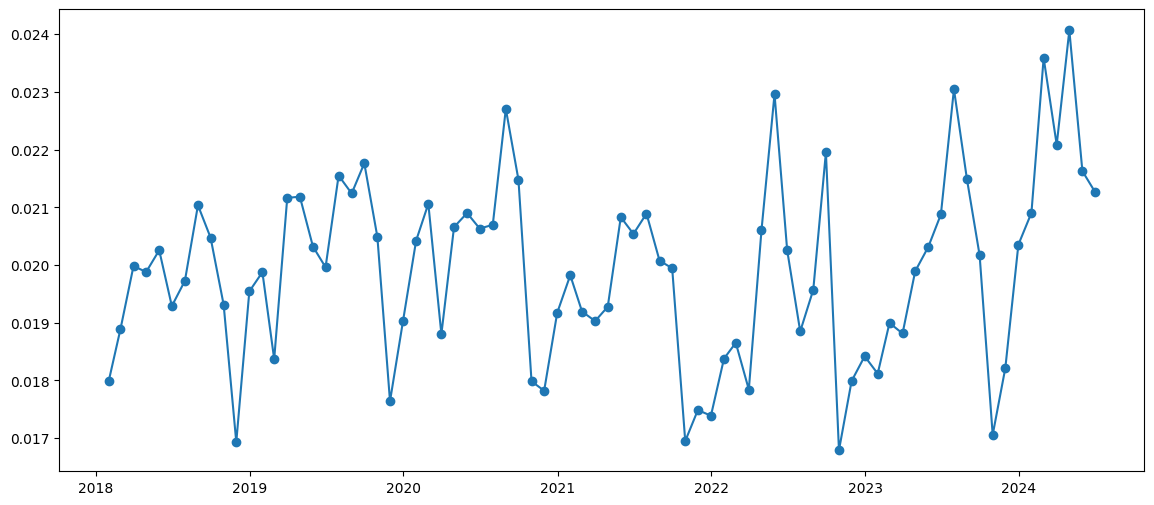

In [28]:
plt.figure(figsize=(14,6))

months = pd.date_range("2018-01", periods=len(next(iter(pollutant_data.values()))), freq="M")

for pollutant, monthly_avg in pollutant_data.items():
    plt.plot(months, monthly_avg, marker='o', label=pollutant)

plt.title("JKIA Pollutants Monthly Averages (2018–2025)")
plt.xlabel("Month")
plt.ylabel("Average Concentration")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Save figure
plt.savefig(os.path.join(charts_path, "JKIA_Pollutants_Monthly_Comparison.png"))
plt.show()


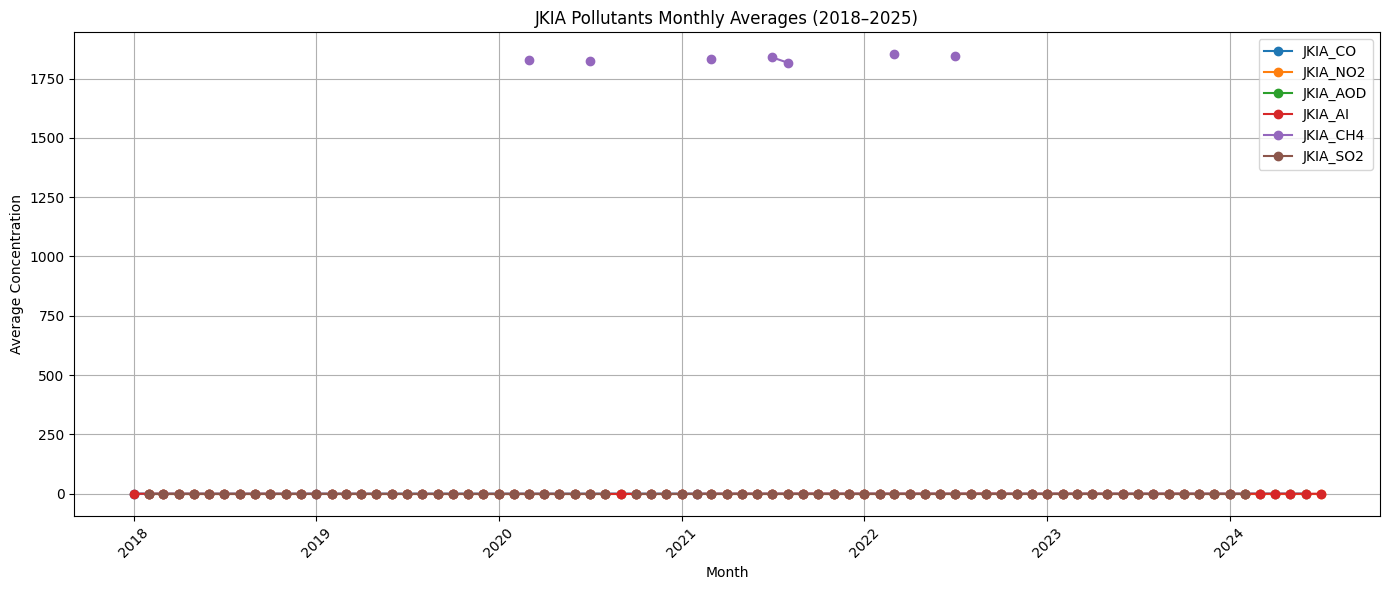

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Example: pollutant_data is a dictionary where keys are pollutant names
# and values are lists/arrays of monthly averages
# pollutant_data = {
#     "NO2": [...],
#     "CO": [...],
#     ...
# }

# 1️⃣ Determine max time range
# Assume first pollutant has the most months
all_lengths = [len(v) for v in pollutant_data.values()]
max_len = max(all_lengths)

# Create months index using start date and max_len
months = pd.date_range("2018-01", periods=max_len, freq="MS")  # month-start

# 2️⃣ Align all pollutants
aligned_data = {}
for pollutant, data in pollutant_data.items():
    # If shorter, pad with NaN at the end
    if len(data) < max_len:
        padded = list(data) + [np.nan]*(max_len - len(data))
    else:
        padded = data
    aligned_data[pollutant] = padded

# 3️⃣ Plot
plt.figure(figsize=(14,6))
for pollutant, monthly_avg in aligned_data.items():
    plt.plot(months, monthly_avg, marker='o', label=pollutant)

plt.title("JKIA Pollutants Monthly Averages (2018–2025)")
plt.xlabel("Month")
plt.ylabel("Average Concentration")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Save figure
charts_path = "/content/drive/MyDrive/JKIA_Charts"  # change as needed
os.makedirs(charts_path, exist_ok=True)
plt.savefig(os.path.join(charts_path, "JKIA_Pollutants_Monthly_Comparison.png"))
plt.show()


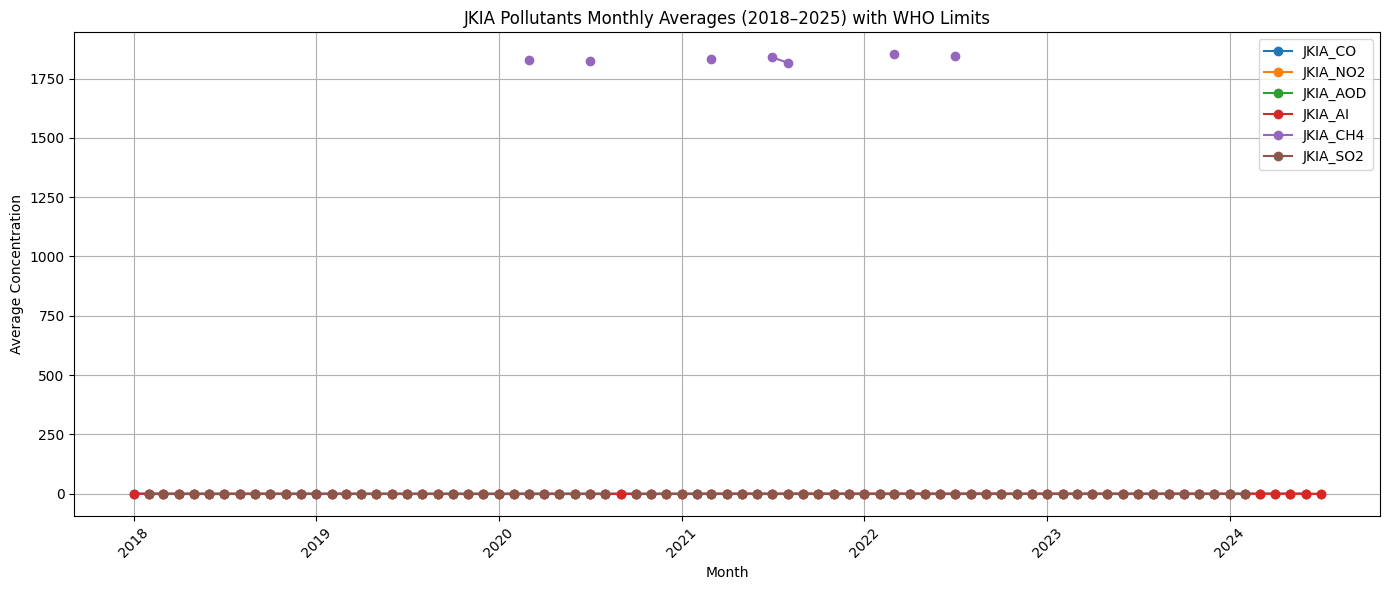

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Example: pollutant_data dictionary
# Keys = pollutant names, Values = monthly averages
# pollutant_data = {"NO2": [...], "CO": [...], ...}

# WHO guideline values (annual mean or relevant)
who_limits = {
    "NO2": 40,      # µg/m³
    "CO": 10,       # mg/m³  (or convert if needed)
    "SO2": 20,      # µg/m³
    "O3": 100,      # µg/m³  (8-hr max)
    "AOD": 0.3,     # dimensionless, indicative
    "AI": 1.0       # arbitrary units, indicative
}

# 1️⃣ Determine max time range
max_len = max(len(v) for v in pollutant_data.values())
months = pd.date_range("2018-01", periods=max_len, freq="MS")  # month start

# 2️⃣ Align all pollutants
aligned_data = {}
for pollutant, data in pollutant_data.items():
    padded = list(data) + [np.nan]*(max_len - len(data)) if len(data) < max_len else data
    aligned_data[pollutant] = padded

# 3️⃣ Plot
plt.figure(figsize=(14,6))
for pollutant, monthly_avg in aligned_data.items():
    plt.plot(months, monthly_avg, marker='o', label=pollutant)

    # Plot WHO limit line
    if pollutant in who_limits:
        plt.axhline(y=who_limits[pollutant], color='r', linestyle='--', alpha=0.5)
        plt.text(months[-1], who_limits[pollutant], f"{pollutant} WHO", color='r', va='bottom')

plt.title("JKIA Pollutants Monthly Averages (2018–2025) with WHO Limits")
plt.xlabel("Month")
plt.ylabel("Average Concentration")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Save figure
charts_path = "/content/drive/MyDrive/JKIA_Charts"  # change if needed
os.makedirs(charts_path, exist_ok=True)
plt.savefig(os.path.join(charts_path, "JKIA_Pollutants_Monthly_Comparison_WHO.png"))
plt.show()


In [31]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np

# Example: pollutant_data dictionary
# pollutant_data = {"NO2": [...], "CO": [...], "SO2": [...], "O3": [...], "AOD": [...], "AI": [...]}

# Align all pollutants
max_len = max(len(v) for v in pollutant_data.values())
months = pd.date_range("2018-01", periods=max_len, freq="MS")

aligned_data = {}
for pollutant, data in pollutant_data.items():
    padded = list(data) + [np.nan]*(max_len - len(data)) if len(data) < max_len else data
    aligned_data[pollutant] = padded

# WHO guideline values (optional reference)
who_limits = {
    "NO2": 40,
    "CO": 10,
    "SO2": 20,
    "O3": 100,
    "AOD": 0.3,
    "AI": 1.0
}

# Create Plotly figure
fig = go.Figure()

# Assign y-axes: left for main pollutants, right for AOD/AI
yaxis_map = {
    "NO2": "y1",
    "CO": "y1",
    "SO2": "y1",
    "O3": "y1",
    "AOD": "y2",
    "AI": "y2"
}

# Add lines
for pollutant, values in aligned_data.items():
    fig.add_trace(go.Scatter(
        x=months, y=values,
        mode='lines+markers',
        name=pollutant,
        yaxis=yaxis_map[pollutant]
    ))

# Layout with two y-axes
fig.update_layout(
    title="JKIA Pollutants Monthly Averages (2018–2025)",
    xaxis=dict(title="Month"),
    yaxis=dict(title="Concentration (µg/m³ / mg/m³)", side="left"),
    yaxis2=dict(title="AOD / AI (dimensionless)", overlaying="y", side="right"),
    legend=dict(x=1.05, y=1.0),
    width=1200,
    height=600
)

fig.show()


KeyError: 'JKIA_CO'

In [32]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np

# Example: pollutant_data keys are 'JKIA_NO2', 'JKIA_CO', etc.
# pollutant_data = {"JKIA_NO2": [...], "JKIA_CO": [...], "JKIA_SO2": [...], "JKIA_O3": [...], "JKIA_AOD": [...], "JKIA_AI": [...]}

# Align all pollutants
max_len = max(len(v) for v in pollutant_data.values())
months = pd.date_range("2018-01", periods=max_len, freq="MS")

aligned_data = {}
for pollutant, data in pollutant_data.items():
    padded = list(data) + [np.nan]*(max_len - len(data)) if len(data) < max_len else data
    aligned_data[pollutant] = padded

# Map full names to short codes for y-axis assignment
yaxis_map = {
    "NO2": "y1",
    "CO": "y1",
    "SO2": "y1",
    "O3": "y1",
    "AOD": "y2",
    "AI": "y2"
}

fig = go.Figure()

for full_name, values in aligned_data.items():
    # Extract pollutant code (assumes format 'JKIA_XXX')
    code = full_name.split("_")[-1]
    yaxis = yaxis_map.get(code, "y1")  # default to y1 if not found

    fig.add_trace(go.Scatter(
        x=months,
        y=values,
        mode='lines+markers',
        name=full_name,
        yaxis=yaxis
    ))

fig.update_layout(
    title="JKIA Pollutants Monthly Averages (2018–2025)",
    xaxis=dict(title="Month"),
    yaxis=dict(title="Concentration (µg/m³ / mg/m³)", side="left"),
    yaxis2=dict(title="AOD / AI (dimensionless)", overlaying="y", side="right"),
    legend=dict(x=1.05, y=1.0),
    width=1200,
    height=600
)

fig.show()


In [33]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np

# Align all pollutants
max_len = max(len(v) for v in pollutant_data.values())
months = pd.date_range("2018-01", periods=max_len, freq="MS")

aligned_data = {}
for pollutant, data in pollutant_data.items():
    padded = list(data) + [np.nan]*(max_len - len(data)) if len(data) < max_len else data
    aligned_data[pollutant] = padded

# Assign left vs right y-axis
yaxis_map = {
    "NO2": "y1",
    "CO": "y1",
    "SO2": "y1",
    "O3": "y1",
    "AOD": "y2",
    "AI": "y2"
}

fig = go.Figure()

# Compute min/max per pollutant for better scaling
for full_name, values in aligned_data.items():
    code = full_name.split("_")[-1]
    yaxis = yaxis_map.get(code, "y1")

    # Scale left-axis pollutants separately
    if yaxis == "y1":
        values_scaled = np.array(values)
        # Simple rescaling to 0–1 for visibility, keeps shape
        values_scaled = (values_scaled - np.nanmin(values_scaled)) / (np.nanmax(values_scaled) - np.nanmin(values_scaled))
    else:
        values_scaled = values  # keep AOD/AI as is

    fig.add_trace(go.Scatter(
        x=months,
        y=values_scaled,
        mode='lines+markers',
        name=full_name,
        yaxis=yaxis
    ))

fig.update_layout(
    title="JKIA Pollutants Monthly Averages (2018–2025) - Scaled Left Axis",
    xaxis=dict(title="Month"),
    yaxis=dict(title="Scaled Concentration (0–1)", side="left"),
    yaxis2=dict(title="AOD / AI (dimensionless)", overlaying="y", side="right"),
    legend=dict(x=1.05, y=1.0),
    width=1200,
    height=600
)

fig.show()


In [34]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# ------------------------
# Example pollutant data
# ------------------------
# pollutant_data = {
#     "NO2": [...], "CO": [...], "SO2": [...],
#     "O3": [...], "AOD": [...], "AI": [...]
# }

months = pd.date_range("2018-01", periods=max(len(v) for v in pollutant_data.values()), freq="MS")

# WHO guideline limits (example, adjust as needed)
who_limits = {
    "NO2": 200,  # µg/m³ monthly
    "CO": 10,    # mg/m³ 8-hour
    "SO2": 20,   # µg/m³ 24-hour
    "O3": 100,   # µg/m³ 8-hour
    "AOD": 0.3,  # dimensionless
    "AI": 0.5    # dimensionless
}

fig = go.Figure()

for pollutant, values in pollutant_data.items():
    # Ensure length matches months
    values = np.array(values)
    if len(values) < len(months):
        values = np.append(values, [np.nan]*(len(months)-len(values)))

    # Highlight points above WHO limit
    above_limit = np.where(values > who_limits.get(pollutant, np.inf), values, np.nan)
    below_limit = np.where(values <= who_limits.get(pollutant, np.inf), values, np.nan)

    # Plot normal points
    fig.add_trace(go.Scatter(
        x=months,
        y=below_limit,
        mode='lines+markers',
        name=pollutant,
        marker=dict(color='blue'),
        visible=True  # all visible by default
    ))

    # Plot points above WHO limit in red
    fig.add_trace(go.Scatter(
        x=months,
        y=above_limit,
        mode='markers',
        name=f"{pollutant} above WHO",
        marker=dict(color='red', size=8, symbol='circle'),
        visible=True
    ))

# Layout
fig.update_layout(
    title="JKIA Monthly Pollutants (2018–2025) - WHO Limits Highlighted",
    xaxis=dict(title="Month"),
    yaxis=dict(title="Concentration / Index"),
    width=1200,
    height=600,
    hovermode='x unified'
)

# Add interactive dropdown to show/hide pollutants
buttons = []
for pollutant in pollutant_data.keys():
    visibility = []
    for p in pollutant_data.keys():
        # show both normal and above-limit traces only for selected pollutant
        visibility += [p == pollutant, p == pollutant]
    buttons.append(dict(
        label=pollutant,
        method="update",
        args=[{"visible": visibility}]
    ))

# Add "Show All" button
buttons.append(dict(
    label="Show All",
    method="update",
    args=[{"visible": [True]*len(fig.data)}]
))

fig.update_layout(
    updatemenus=[dict(active=0, buttons=buttons, x=1.05, y=1)]
)

fig.show()


In [35]:
import numpy as np
import pandas as pd

# Ensure all pollutant arrays match the timeline
max_len = max(len(v) for v in pollutant_data.values())
months = pd.date_range("2018-01", periods=max_len, freq="MS")

for pollutant, values in pollutant_data.items():
    values = np.array(values, dtype=float)

    # Replace missing or invalid data with NaN
    values[values == 0] = np.nan   # optional, if 0 means missing
    if len(values) < max_len:
        values = np.append(values, [np.nan]*(max_len - len(values)))
    pollutant_data[pollutant] = values


In [36]:
import plotly.graph_objects as go

fig = go.Figure()
yaxis_map = {}  # map pollutant -> yaxis

for i, (pollutant, values) in enumerate(pollutant_data.items()):
    axis = f'y{i+1}' if i>0 else 'y'
    yaxis_map[pollutant] = axis

    # Plot normal points
    fig.add_trace(go.Scatter(
        x=months,
        y=values,
        mode='lines+markers',
        name=pollutant,
        marker=dict(color='blue'),
        yaxis=axis
    ))

# Layout for multiple y-axes
layout = dict(title="JKIA Pollutants (2018–2025)",
              xaxis=dict(title="Month"),
              yaxis=dict(title=list(pollutant_data.keys())[0]),
              width=1200, height=600)

# Add extra y-axes
for i, pollutant in enumerate(list(pollutant_data.keys())[1:]):
    layout[f'yaxis{i+2}'] = dict(title=pollutant, overlaying='y', side='right', position=1-0.05*i)

fig.update_layout(layout)
fig.show()


In [37]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# ---------------------------
# Sample pollutant data dict
# ---------------------------
# Replace this with your real monthly averages for each pollutant
pollutant_data = {
    "NO2": np.random.rand(78)*0.0003,
    "CO": np.random.rand(78)*0.1,
    "SO2": np.random.rand(78)*0.00005,
    "CH4": np.random.rand(78)*0.002,
    "AOD": np.random.rand(78)*0.5,
    "UVAI": np.random.rand(78)*1.0
}

# Monthly timeline
months = pd.date_range("2018-01", periods=78, freq="MS")

# ---------------------------
# Define color stages per pollutant
# ---------------------------
# Adjust thresholds based on WHO or your dataset
color_stages = {
    "NO2": [0, 0.00005, 0.0001, 0.00015, 0.0002, 0.0003],
    "CO": [0, 0.02, 0.04, 0.06, 0.08, 0.1],
    "SO2": [0, 0.00001, 0.00002, 0.00003, 0.00004, 0.00005],
    "CH4": [0, 0.0004, 0.0008, 0.0012, 0.0016, 0.002],
    "AOD": [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    "UVAI": [0, 0.2, 0.4, 0.6, 0.8, 1.0]
}

# Define colors for stages (from green → yellow → orange → pink → purple)
stage_colors = ["green", "yellow", "orange", "pink", "purple"]

# ---------------------------
# Function to map value → color
# ---------------------------
def get_colors(pollutant, values):
    thresholds = color_stages[pollutant]
    colors = []
    for v in values:
        if np.isnan(v):
            colors.append("gray")
        else:
            for i in range(1, len(thresholds)):
                if v <= thresholds[i]:
                    colors.append(stage_colors[i-1])
                    break
    return colors

# ---------------------------
# Build Plotly figure
# ---------------------------
fig = go.Figure()
for i, (pollutant, values) in enumerate(pollutant_data.items()):
    fig.add_trace(go.Scatter(
        x=months,
        y=values,
        mode='markers+lines',
        marker=dict(color=get_colors(pollutant, values), size=8),
        line=dict(color="black", width=1),
        name=pollutant,
        visible=True
    ))

# ---------------------------
# Layout
# ---------------------------
fig.update_layout(
    title="JKIA Pollutants Monthly Averages (2018–2025)",
    xaxis=dict(title="Month"),
    yaxis=dict(title="Concentration"),
    width=1200,
    height=600
)

# ---------------------------
# Dropdown to select pollutants
# ---------------------------
buttons = []
for i, pollutant in enumerate(pollutant_data.keys()):
    visible = [False]*len(pollutant_data)
    visible[i] = True
    buttons.append(dict(label=pollutant,
                        method="update",
                        args=[{"visible": visible},
                              {"title": f"{pollutant} Monthly Average"}]))

# Add option to show all
buttons.append(dict(label="All",
                    method="update",
                    args=[{"visible": [True]*len(pollutant_data)},
                          {"title": "All Pollutants Monthly Averages"}]))

fig.update_layout(
    updatemenus=[dict(active=0, buttons=buttons, x=1.15, y=0.8)]
)

fig.show()


In [38]:
import os
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# --------------------------
# Paths
# --------------------------
csv_folder = "/content/drive/MyDrive/Pollutants/fn"

# --------------------------
# Read CSVs and prepare data
# --------------------------
pollutant_data = {}  # dictionary to store monthly averages

for file in os.listdir(csv_folder):
    if file.endswith(".csv"):
        pollutant_name = file.split("_")[1]  # assuming filename like JKIA_NO2_monthly_2018_2025.csv
        df = pd.read_csv(os.path.join(csv_folder, file))

        # Convert 'Date' column to datetime if it exists
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])
        elif 'date' in df.columns:
            df['Date'] = pd.to_datetime(df['date'])
        else:
            raise ValueError(f"No date column found in {file}")

        # Take monthly average if multiple values per month
        df_monthly = df.groupby(df['Date'].dt.to_period('M')).mean()

        # Save as list of monthly averages
        pollutant_data[pollutant_name] = df_monthly.iloc[:, 0].values  # take first numeric column

# --------------------------
# Prepare timeline
# --------------------------
months = pd.date_range(start="2018-01", periods=len(next(iter(pollutant_data.values()))), freq="M")

# --------------------------
# Plot interactive chart
# --------------------------
fig = go.Figure()

colors = {
    "NO2": "blue",
    "CO": "green",
    "SO2": "orange",
    "CH4": "purple",
    "AOD": "brown",
    "UVAI": "cyan"
}

# WHO limits for reference (example values, adjust if needed)
who_limits = {
    "NO2": 200,
    "CO": 1000,
    "SO2": 125,
    "CH4": 1000,
    "AOD": 0.3,
    "UVAI": 0.5
}

for pollutant, values in pollutant_data.items():
    # Determine colors based on levels (5 stages)
    stage_colors = []
    v = np.array(values)
    v_min, v_max = np.nanmin(v), np.nanmax(v)
    thresholds = np.linspace(v_min, v_max, 5)
    for val in v:
        if np.isnan(val):
            stage_colors.append("lightgray")
        elif val <= thresholds[1]:
            stage_colors.append("green")
        elif val <= thresholds[2]:
            stage_colors.append("yellow")
        elif val <= thresholds[3]:
            stage_colors.append("orange")
        else:
            stage_colors.append("red")

    fig.add_trace(go.Scatter(
        x=months,
        y=values,
        mode='lines+markers',
        marker=dict(color=stage_colors, size=8),
        line=dict(color=colors.get(pollutant, "black")),
        name=pollutant
    ))

fig.update_layout(
    title="JKIA Pollutants Monthly Averages (2018–2025)",
    xaxis_title="Month",
    yaxis_title="Concentration / Index",
    xaxis=dict(rangeslider=dict(visible=True)),
    legend_title="Pollutants",
    hovermode="x unified"
)

fig.show()


ValueError: No date column found in JKIA_NO2_monthly_2018_2025.csv

In [39]:
import pandas as pd
import os

csv_folder = "/content/drive/MyDrive/Pollutants/fn"

for file in os.listdir(csv_folder):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(csv_folder, file))
        print(f"File: {file}")
        print("Columns:", df.columns.tolist())
        print(df.head(3))
        print("-"*40)


File: JKIA_NO2_monthly_2018_2025.csv
Columns: ['system:index', 'month', 'year', '.geo']
   system:index  month    year                                    .geo
0             0    1.0  2018.0  {"type":"MultiPoint","coordinates":[]}
1             1    2.0  2018.0  {"type":"MultiPoint","coordinates":[]}
2             2    3.0  2018.0  {"type":"MultiPoint","coordinates":[]}
----------------------------------------
File: JKIA_CO_monthly_2018_2025.csv
Columns: ['system:index', 'month', 'year', '.geo']
   system:index  month    year                                    .geo
0             0    1.0  2018.0  {"type":"MultiPoint","coordinates":[]}
1             1    2.0  2018.0  {"type":"MultiPoint","coordinates":[]}
2             2    3.0  2018.0  {"type":"MultiPoint","coordinates":[]}
----------------------------------------
File: JKIA_SO2_monthly_2018_2025.csv
Columns: ['system:index', 'month', 'year', '.geo']
   system:index  month    year                                    .geo
0             0 

In [40]:
import pandas as pd
import os

csv_folder = "/content/drive/MyDrive/Pollutants/fn"
pollutant_data = {}

for file in os.listdir(csv_folder):
    if file.endswith(".csv"):
        path = os.path.join(csv_folder, file)
        df = pd.read_csv(path)

        # Create datetime from month + year
        if 'month' in df.columns and 'year' in df.columns:
            df['Date'] = pd.to_datetime(df['year'].astype(int).astype(str) + '-' + df['month'].astype(int).astype(str) + '-01')
        elif 'Optical_Depth_047' in df.columns:
            # For AOD
            df['Date'] = pd.to_datetime(df['year'].astype(int).astype(str) + '-' + df['month'].astype(int).astype(str) + '-01')
        else:
            raise ValueError(f"No suitable date columns found in {file}")

        # Identify value column
        value_cols = [c for c in df.columns if c not in ['system:index','month','year','.geo','Date']]
        if len(value_cols) == 0:
            raise ValueError(f"No value column found in {file}")
        value_col = value_cols[0]

        # Sort by date and fill missing months if necessary
        df = df.sort_values('Date')
        df = df.set_index('Date').resample('M').mean()  # monthly resample
        pollutant_name = file.split('_monthly')[0].replace("JKIA_","")
        pollutant_data[pollutant_name] = df[value_col]

print("✅ All pollutants loaded and prepared.")


ValueError: No value column found in JKIA_NO2_monthly_2018_2025.csv

In [41]:
import pandas as pd
import plotly.graph_objects as go
import os

# ===========================
# Paths
# ===========================
fn_path = "/content/drive/MyDrive/Pollutants/fn"
charts_path = "/content/drive/MyDrive/JKIA_Charts"
os.makedirs(charts_path, exist_ok=True)

# ===========================
# Load CSVs that have values
# ===========================
pollutant_data = {}

# AOD
aod_file = os.path.join(fn_path, "JKIA_AOD_monthly_2018_2025.csv")
df_aod = pd.read_csv(aod_file)
df_aod['Date'] = pd.to_datetime(df_aod[['year','month']].assign(DAY=1))
pollutant_data['AOD'] = df_aod[['Date','Optical_Depth_047']].rename(columns={'Optical_Depth_047':'Value'})

# ===========================
# Define color stages (5 stages)
# ===========================
def assign_stage(value, pollutant):
    # Example thresholds, adjust later to WHO or domain-specific
    if pollutant == "AOD":
        bins = [0, 100, 200, 300, 400, 10000]  # Adjust according to your actual AOD values
        colors = ["green", "yellowgreen", "yellow", "orange", "red"]
    else:
        bins = [0, 50, 100, 150, 200, 10000]
        colors = ["green", "yellowgreen", "yellow", "orange", "red"]

    for i in range(len(bins)-1):
        if bins[i] <= value < bins[i+1]:
            return colors[i]
    return colors[-1]

pollutant_data['AOD']['Color'] = pollutant_data['AOD']['Value'].apply(lambda x: assign_stage(x, "AOD"))

# ===========================
# Plotly interactive chart
# ===========================
fig = go.Figure()

for pollutant, df in pollutant_data.items():
    fig.add_trace(go.Scatter(
        x=df['Date'],
        y=df['Value'],
        mode='lines+markers',
        marker=dict(color=df['Color'], size=8),
        name=pollutant
    ))

# Layout
fig.update_layout(
    title="JKIA Pollutants Monthly Values (AOD shown)",
    xaxis_title="Date",
    yaxis_title="Pollutant Value",
    hovermode='x unified'
)

# Show figure
fig.show()

# Save as HTML interactive chart
fig.write_html(os.path.join(charts_path, "JKIA_AOD_Interactive.html"))


In [42]:
import pandas as pd
import plotly.graph_objects as go
import os

# ===========================
# Paths
# ===========================
fn_path = "/content/drive/MyDrive/Pollutants/fn"
charts_path = "/content/drive/MyDrive/JKIA_Charts"
os.makedirs(charts_path, exist_ok=True)

# ===========================
# Load CSVs that have values
# ===========================
aod_file = os.path.join(fn_path, "JKIA_AOD_monthly_2018_2025.csv")
df_aod = pd.read_csv(aod_file)
df_aod['Date'] = pd.to_datetime(df_aod[['year','month']].assign(DAY=1))
df_aod = df_aod.sort_values('Date')

# ===========================
# Define color stages (5 stages)
# ===========================
def assign_stage(value, pollutant):
    bins = [0, 100, 200, 300, 400, 10000]  # Adjust for actual AOD
    colors = ["green", "yellowgreen", "yellow", "orange", "red"]
    for i in range(len(bins)-1):
        if bins[i] <= value < bins[i+1]:
            return colors[i]
    return colors[-1]

df_aod['Color'] = df_aod['Optical_Depth_047'].apply(lambda x: assign_stage(x, "AOD"))

# ===========================
# Build figure with colored segments
# ===========================
fig = go.Figure()

dates = df_aod['Date'].tolist()
values = df_aod['Optical_Depth_047'].tolist()
colors = df_aod['Color'].tolist()

for i in range(len(values)-1):
    # Determine line color
    if colors[i] == colors[i+1]:
        line_color = colors[i]
    else:
        line_color = 'black'  # Transition between stages

    fig.add_trace(go.Scatter(
        x=[dates[i], dates[i+1]],
        y=[values[i], values[i+1]],
        mode='lines+markers',
        marker=dict(color=colors[i], size=8),
        line=dict(color=line_color, width=2),
        showlegend=False  # Avoid multiple legend entries
    ))

# Add points for last date (to make sure it's plotted)
fig.add_trace(go.Scatter(
    x=[dates[-1]],
    y=[values[-1]],
    mode='markers',
    marker=dict(color=colors[-1], size=8),
    name='AOD'
))

# Layout
fig.update_layout(
    title="JKIA AOD Monthly Values with Stage-Colored Lines",
    xaxis_title="Date",
    yaxis_title="AOD Value",
    hovermode='x unified'
)

fig.show()
fig.write_html(os.path.join(charts_path, "JKIA_AOD_ColoredSegments.html"))


In [43]:
import pandas as pd
import plotly.graph_objects as go
import os

# ===========================
# Paths
# ===========================
fn_path = "/content/drive/MyDrive/Pollutants/fn"
charts_path = "/content/drive/MyDrive/JKIA_Charts"
os.makedirs(charts_path, exist_ok=True)

# ===========================
# Load CSV
# ===========================
aod_file = os.path.join(fn_path, "JKIA_AOD_monthly_2018_2025.csv")
df = pd.read_csv(aod_file)
df['Date'] = pd.to_datetime(df[['year','month']].assign(DAY=1))
df = df.sort_values('Date')

# ===========================
# Define stages and colors
# ===========================
bins = [0, 100, 200, 300, 400, 10000]   # adjust per pollutant scale
colors = ["green", "yellowgreen", "yellow", "orange", "red"]
labels = ["Very Low", "Low", "Moderate", "High", "Very High"]

def get_stage_color(value):
    for i in range(len(bins)-1):
        if bins[i] <= value < bins[i+1]:
            return colors[i]
    return colors[-1]

df['Color'] = df['Optical_Depth_047'].apply(get_stage_color)

# ===========================
# Plot segments
# ===========================
fig = go.Figure()

dates = df['Date'].tolist()
values = df['Optical_Depth_047'].tolist()
colors_list = df['Color'].tolist()

for i in range(len(values)-1):
    # Line color: same stage → use stage color, else black
    line_color = colors_list[i] if colors_list[i] == colors_list[i+1] else 'black'

    fig.add_trace(go.Scatter(
        x=[dates[i], dates[i+1]],
        y=[values[i], values[i+1]],
        mode='lines+markers',
        marker=dict(color=colors_list[i], size=8),
        line=dict(color=line_color, width=2),
        showlegend=False
    ))

# Add last point
fig.add_trace(go.Scatter(
    x=[dates[-1]],
    y=[values[-1]],
    mode='markers',
    marker=dict(color=colors_list[-1], size=8),
    name='AOD'
))

# ===========================
# Add custom legend
# ===========================
for c, l in zip(colors, labels):
    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        marker=dict(color=c, size=10),
        legendgroup='Stages',
        showlegend=True,
        name=l
    ))

# ===========================
# Layout
# ===========================
fig.update_layout(
    title="JKIA AOD Monthly Values with Stage-Colored Lines",
    xaxis_title="Date",
    yaxis_title="AOD Value",
    hovermode='x unified'
)

fig.show()
fig.write_html(os.path.join(charts_path, "JKIA_AOD_ColoredSegments.html"))
